##### Modelo SEIR (Susceptibles, Expuestos, Infectados, Recuperados, Fallecidos) + Detectados

In [30]:
import numpy as np
import scipy
import scipy.integrate

from utilidades import *

def seir_model(SEIR, beta, sigma, gamma, mu, theta=0, beta_d=0):
    S, E, I, D, R, F = SEIR

    # Poblacion
    N = S + E + I + D + R

    # - Los susceptibles que pasan a expuestos a razon `beta` a partir de contacto con infectados no detectados
    # - Los susceptibles que pasan a expuestos a razon `beta_d` a partir de contacto con infectados detectados
    dS = - beta * S * I / N - beta_d * S * D / N
    # + Los susceptibles que pasan a expuestos a razon `beta` a partir de contacto con infectados no detectados
    # + Los susceptibles que pasan a expuestos a razon `beta_d` a partir de contacto con infectados detectados
    # - Los expuestos que pasan a infectados a razon `sigma`
    dE = beta * S * I / N + beta_d * S * D / N - sigma * E
    # + Los expuestos que pasan a infectados no detectados a razon `sigma`
    # - Los infectados no detectados que pasan a recuperados a razon `gamma`
    # - Los infectados no detectados que pasan a fallecidos a razon `mu`
    # - Los infectados no detectados que pasan a detectados a razon `theta`
    dI = sigma * E - gamma * I - mu * I - theta * I
    # + Los infectados no detectados que pasan a detectados a razon `theta`
    # - Los detectados que pasan a recuperados a razon `gamma`
    # - Los detectados que pasan a fallecidos a razon `mu`
    dD = theta * I - gamma * D - mu * D
    # + Los infectados no detectados que pasan a recuperados a razon `gamma`
    # + Los detectados que pasan a recuperados a razon `gamma`
    dR = gamma * I + gamma * D
    # + Los infectados no detectados que pasan a fallecidos a razon `mu`
    # + Los detectados que pasan a fallecidos a razon `mu`
    dF = mu * I + mu * D

    return [
        dS, dE, dI, dD, dR, dF
    ]

Clases:
    * Susceptible
    * Expuesto
    * Infectado
    * Recuperado
    * Fallecido
Nueva Clase:
    * Detectado
    
Parametros:  
    * `beta` es la razon de transmision  
    * `sigma` es la razon de transicion de Expuesto a Infectado  
    * `gamma` es la razon de transicion de Infectado a Recuperado (o aislado)  
    * `mu` es la razon de transicion de Infectado a Fallecido
Nuevos Parametros:  
    * `theta` es la razon de transicion de Infectado a Detectado  
    * `beta_d` es la razon de transmision de los Detectados  


In [2]:
periodo_incubacion = 5.2
periodo_infeccioso = 12.4
razon_mortalidad = 3. / 100

susceptibles_t0 = 11e6

data = load_data()

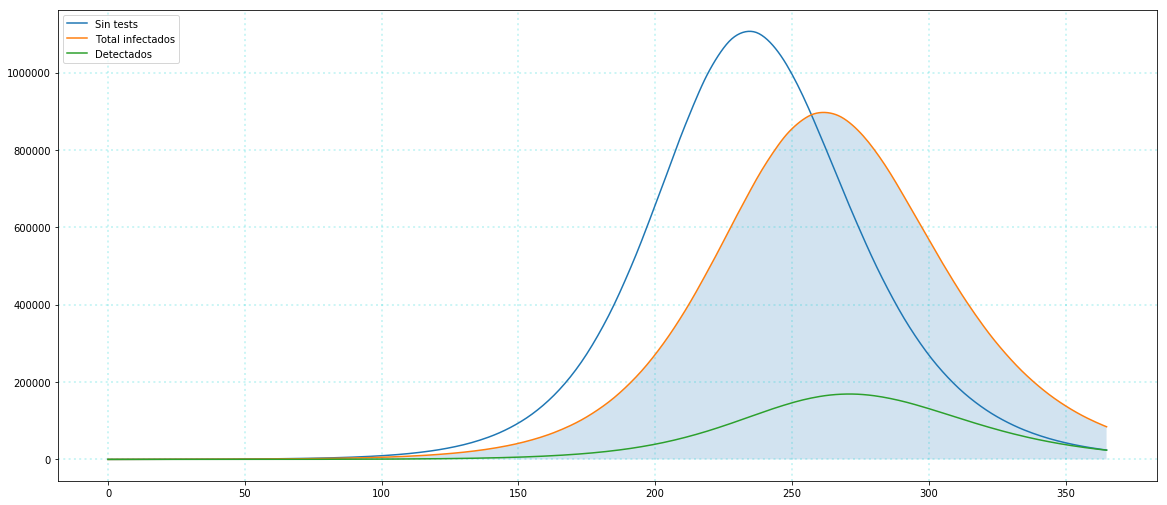

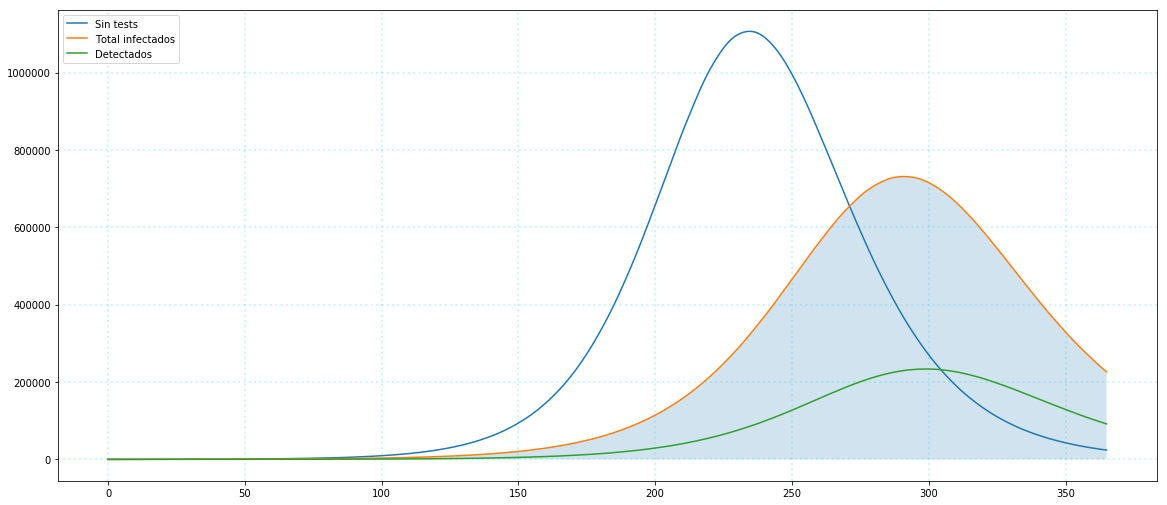

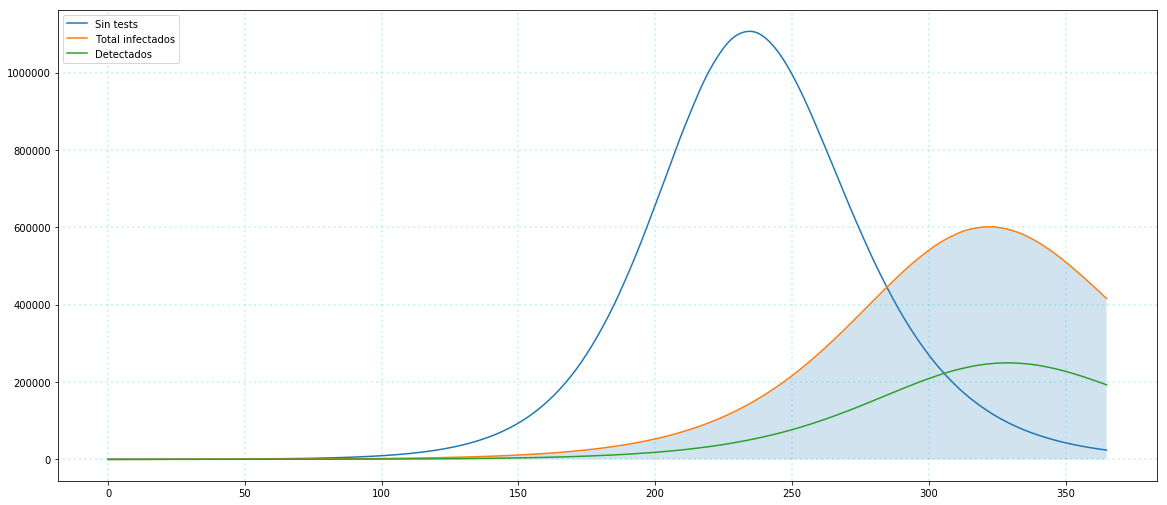

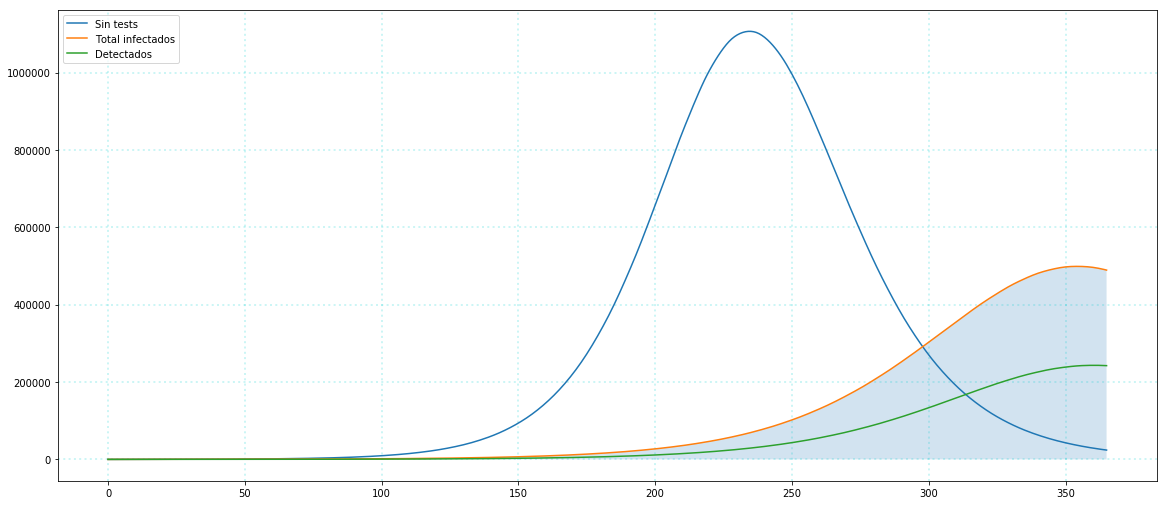

In [28]:
def run_model(args):
    infectados_t0, R_t0, R_t1, theta = args
    
    SEIR_t0 = (
        susceptibles_t0,
        infectados_t0 * R_t0,
        infectados_t0,
        0, 0, 0
    )
    return run(
        seir_model,
        SEIR_t0,
        beta = [R0 / periodo_infeccioso for R0 in (R_t0, R_t1)],
        sigma = 1. / periodo_incubacion,
        gamma = 1. / periodo_infeccioso,
        mu = razon_mortalidad / periodo_infeccioso,
        theta = theta,
        beta_d = 1. / periodo_infeccioso,
        days = days,
        step = 1
    )

days = [12, 365 - 12]

solutions = [(theta, run_model((16., 3.9, 2., theta))) for theta in np.arange(start=0., stop=0.1, step=0.02)]

solutions_x = solutions[0][1]['t']
solutions = [(theta, sol['y'][3], sol['y'][3] + sol['y'][2]) for theta, sol in solutions]
theta, sol_d, sol_it = zip(*solutions)


for _ in range(1, len(solutions)):
    ax = plot(solutions_x, sol_it[0], labels=['Sin tests'])
    ax.plot(solutions_x, sol_it[_], label='Total infectados')
    ax.plot(solutions_x, sol_d[_], label='Detectados')
    ax.fill_between(
        solutions_x,
        sol_d[0],
        sol_it[_],
        alpha=0.2
    )
    ax.legend(loc='upper left')

`theta` y `beta_d` describen cuantos y cuan rapido se detecto y que tan bien se aislo a los infectados.  
Muchas cosas por hacer todavia aqui, lo mas importante `REGRESION`